In [1]:
import mne
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats, signal
import itertools
import pandas as pd
from datetime import datetime

In [2]:
# consts
threshold_env = 8  
threshold_amp = 5  
threshold_grad = 5
use_env = True
use_amp = True
use_grad = True
block_size_sec = 10  # filter and find peaks at blocks of X seconds - based on Andrillon et al

# the bandpass range is based on Andrillon et al
low_pass = 50
high_pass = 150

# general constants
min_distance = 200  # minimal distance for 'different' spikes - in miliseconds
min_spike_length_sec = 0.004  # a spike is detected if there are points for 5 ms passing the threshold, based on Andrillon et al


In [3]:
def get_markers(data, index_above_threshold, thresh_type):
    max_markers_index = []
    max_marker_value = []

    # find max markers
    #     counter = 1
    curr_spike = []
    curr_spike_data = [thresh_type, index_above_threshold[0]]
    curr_spike.append(index_above_threshold[0])
    for j in range(len(index_above_threshold)):
        # check that the next index is the same spike
        if j + 1 < len(index_above_threshold) and index_above_threshold[j + 1] - index_above_threshold[j] == 1:
            curr_spike.append(index_above_threshold[j + 1])
        # the current spike finished
        else:
            # check min spike length
            if sampling_rate * min_spike_length_sec <= len(curr_spike):
                # check if the peak is positive or negative and append it's value
                max_value = data[curr_spike[0]: curr_spike[-1] + 1].max()
                min_value = data[curr_spike[0]: curr_spike[-1] + 1].min()
                value = max_value if abs(max_value) > abs(min_value) else min_value
                
                # find the index of the spike's peak
                index = np.intersect1d(np.where(data == value)[0], curr_spike)[0]
                max_marker_value.append(value)
                max_markers_index.append(index)
                curr_spike_data.extend((index_above_threshold[j], index, value))
                spikes_list.append(curr_spike_data)
                
            # init data for next spike
            if j + 1 < len(index_above_threshold):
                curr_spike = []
                curr_spike_data = [thresh_type, index_above_threshold[j + 1]]
                
    return np.array(max_markers_index), np.array(max_marker_value)

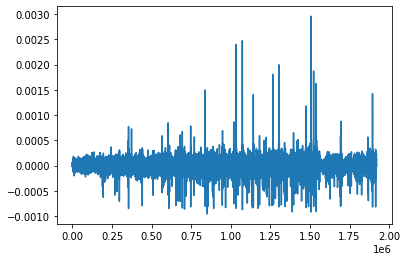

In [4]:
spikes_list = []
# edf = '/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/402_for_tag.edf'
mne.set_log_level(False)
save_csv = True
edf = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\results\\402\\402_for_tag.edf'
raw = mne.io.read_raw_edf(edf)
sampling_rate = int(raw.info['sfreq'])
raw.pick_channels(['RAH1-RAH2'])
# raw.crop(tmin=0, tmax=300)

data = raw.get_data()[0]
plt.plot(data)

In [5]:
points_in_block = block_size_sec * sampling_rate
number_of_blocks = math.floor(len(data) / points_in_block)
max_markers_index_amp, max_markers_index_grad, max_markers_index_env = [], [], []

for i in range(number_of_blocks):
    curr_block = data[i * points_in_block: (i + 1) * points_in_block]

    # check amplitude threshold
    if use_amp or use_amp_env or use_amp_grad:
        z_score_amp = stats.zscore(curr_block)
        points_above_thresh_amp = z_score_amp[z_score_amp > threshold_amp]
        # get indexes from z_score values and add offset of the current block
        if len(points_above_thresh_amp) > 0:
            index_above_threshold_amp = (z_score_amp > threshold_amp).nonzero()[0] + i * points_in_block
            curr_markers_index_amp, curr_markers_value_amp = get_markers(data, index_above_threshold_amp, 'amp')
            max_markers_index_amp.extend(curr_markers_index_amp)


    # check gradient threshold
    if use_grad or use_amp_grad:
        gradient_diff = np.diff(curr_block)
        z_score_grad = stats.zscore(np.insert(gradient_diff, 0, 0))
        points_above_thresh_grad = z_score_grad[z_score_grad > threshold_grad]
        if len(points_above_thresh_grad) > 0:
            index_above_threshold_grad = (z_score_grad > threshold_grad).nonzero()[0] + i * points_in_block
            curr_markers_index_grad, curr_marker_value_grad = get_markers(data, index_above_threshold_grad, 'grad')
            max_markers_index_grad.extend(curr_markers_index_grad)

    # check envelope threshold
    if use_env or use_amp_env:
        filtered_block = mne.filter.filter_data(curr_block, sampling_rate, low_pass, high_pass)
        env_block = abs(signal.hilbert(filtered_block))
        z_score_env = stats.zscore(env_block)
        points_above_thresh_env = z_score_env[z_score_env > threshold_env]
        if len(points_above_thresh_env) > 0:
            index_above_threshold_env = (z_score_env > threshold_env).nonzero()[0] + i * points_in_block
            curr_markers_index_env, curr_marker_value_env = get_markers(data, index_above_threshold_env, 'env')
            max_markers_index_env.extend(curr_markers_index_env)


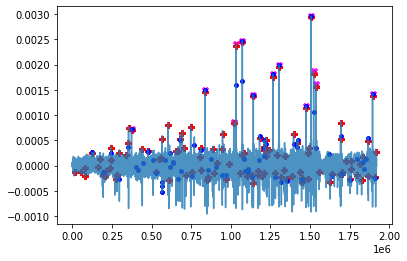

In [6]:
plt.plot(data, alpha=0.8)
plt.scatter(max_markers_index_amp, data[max_markers_index_amp] if len(max_markers_index_amp) > 0 else [], marker='X', color='fuchsia')
plt.scatter(max_markers_index_grad, data[max_markers_index_grad] if len(max_markers_index_grad) > 0 else [], marker='P', color='red')
plt.scatter(max_markers_index_env, data[max_markers_index_env] if len(max_markers_index_env) > 0 else [], marker='o', color='blue', s=15)

In [7]:
# union close spikes
def union_spikes(spikes_df, min_distance_sec, sr):
    new_spikes_list = []
    flag, any_union = False, False
    for i, x in spikes_df.iterrows():
        # prevent double unions
        for j, y in spikes_df[i + 1:].iterrows():
            # check distance between the peaks
            if abs(x['max_index'] - y['max_index']) / sr < min_distance_sec:
                # more than one union with the current spike x
                if flag:
                    thresh_type = list(set([curr_union[0].append(y['threshold_type'])]))
                    max_index, max_amp = (curr_union[3], curr_union[4]) if abs(curr_union[4]) > abs(y['max_amp']) \
                        else (y['max_index'], y['max_amp'])
                    curr_union = [thresh_type, min(x[1], y['first_index']), max(curr_union[2], y['last_index']),
                         max_index, max_amp, abs(curr_union[1] - y['first_index'])]
                else:
                    thresh_type = list(set([x['threshold_type'], y['threshold_type']]))
                    max_index, max_amp = (x['max_index'], x['max_amp']) if abs(x['max_amp']) > abs(y['max_amp']) \
                            else (y['max_index'], y['max_amp'])
                    curr_union = [thresh_type, min(x['first_index'], y['first_index']), max(x['last_index'], y['last_index']),
                         max_index, max_amp, abs(x['first_index'] - y['first_index'])]
                flag, any_union = True, True
        if flag:
            new_spikes_list.append(curr_union)
            flag = False
        else:
            new_spikes_list.append(x.tolist())

    columns = ['threshold_type', 'first_index', 'last_index', 'max_index', 'max_amp', 'start_diff']
    if not any_union:
        columns.remove('start_diff')
    new_spikes_df = pd.DataFrame(new_spikes_list, columns=columns)
    new_spikes_df = new_spikes_df.drop_duplicates(subset='max_index')
    new_spikes_df['duration'] = spikes_df['last_index'] - spikes_df['first_index']
    return new_spikes_df

In [8]:
if save_csv:
    spikes_df = pd.DataFrame(spikes_list, columns=['threshold_type', 'first_index', 'last_index', 'max_index', 'max_amp'])
    spikes_df['duration_sec'] = (spikes_df['last_index'] - spikes_df['first_index']) / sampling_rate
    spikes_df = spikes_df.astype({"max_index": int})
    # start index from 1 instead 0
    spikes_df.index += 1
    spikes_df.to_csv('C:\\Users\\user\\PycharmProjects\\pythonProject\\results\\402\\402_for_tag_spikes.csv')

In [9]:
new_spikes_df = pd.DataFrame(spikes_list, columns=['threshold_type', 'first_index', 'last_index', 'max_index', 'max_amp'])

In [10]:
new_spikes_df

,threshold_type,first_index,last_index,max_index,max_amp
0,grad,16191,16211,16191,-0.000130
1,grad,56805,56828,56805,-0.000122
2,grad,82371,82398,82371,-0.000212
3,grad,82479,82487,82480,-0.000051
4,grad,123744,123768,123768,0.000256
...,...,...,...,...,...
193,grad,1895014,1895046,1895046,0.001385
194,env,1894987,1895064,1895051,0.001424
195,grad,1909639,1909646,1909639,-0.000221
196,grad,1914573,1914599,1914599,0.000275


In [11]:
union_spikes(new_spikes_df, 0.1, sampling_rate)

,threshold_type,first_index,last_index,max_index,max_amp,start_diff,duration
0,grad,16191,16211,16191,-0.000130,NaN,20
1,grad,56805,56828,56805,-0.000122,NaN,23
2,[grad],82371,82487,82371,-0.000212,108.0,27
3,grad,82479,82487,82480,-0.000051,NaN,8
4,"[grad, env]",123744,123797,123769,0.000258,0.0,24
...,...,...,...,...,...,...,...
189,"[grad, env]",1865142,1865179,1865179,0.000551,4.0,25
190,grad,1868711,1868729,1868712,-0.000209,NaN,18
192,[None],1894987,1895068,1895051,0.001424,27.0,34
195,"[grad, env]",1909631,1909653,1909634,-0.000254,8.0,7


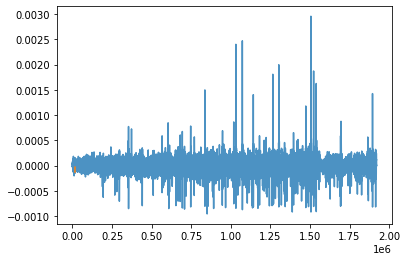

In [12]:
# lines instead of markers
spike_indexes = np.arange(spikes_list[0][1], spikes_list[0][2] + 1)
plt.plot(data, alpha=0.8)
plt.plot(spike_indexes, data[spike_indexes])

In [13]:
x, y = False, False

In [14]:
list(set(['asd', 'asd']))

['asd']

In [15]:
spikes_df.iterrows()

<generator object DataFrame.iterrows at 0x0000029C5C078848>

In [16]:
y

False